In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import pickle
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import torchaudio
import math
import random
import numpy as np
import io
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

Setup / Configs

In [ ]:
assert torch.cuda.is_available(), 'GPU unavailable'

In [ ]:
print('Number of GPUs available : ', torch.cuda.device_count())

Number of GPUs available :  1


In [ ]:
MODEL_CHECKPOINT = '/content/drive/MyDrive/Fall2021-CAPSTONE/checkpoint.pt'

In [ ]:
EVAL_CHECKPOINT = '/content/drive/MyDrive/Fall2021-CAPSTONE/eval_checkpoint.pt'

In [ ]:
TEST_CHECKPOINT = '/content/drive/MyDrive/Fall2021-CAPSTONE/test_checkpoint.pt'

In [ ]:
# zip file handler  
zip = zipfile.ZipFile('/content/drive/MyDrive/Fall2021-CAPSTONE/2-DataPreparation/DataSplits_bkp.zip')

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Load size during training
load_size = 1280

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Vocabulary

In [ ]:
chars = ' abcdefghijklmnopqrstuvwxyz'
vocab = ['<blank>', '<pad>', '<unk>']
for ch in chars:
  vocab.append(ch)

In [ ]:
VOCAB_LEN = len(vocab)
print('Vocab size: {} (with BLNK, PAD, UNK and SPACE added)'.format(VOCAB_LEN))
print('vocab[0]:', vocab[0])
print('vocab[1]:', vocab[1])
print('vocab[2]:', vocab[2])
print('vocab[3]:', vocab[3])

Vocab size: 30 (with BLNK, PAD, UNK and SPACE added)
vocab[0]: <blank>
vocab[1]: <pad>
vocab[2]: <unk>
vocab[3]:  


In [ ]:
with open('/content/drive/MyDrive/Fall2021-CAPSTONE/max_len.pickle', 'rb') as f2:
  MAX_LEN = pickle.load(f2)
print('Max target length : ', MAX_LEN)

Max target length :  105


Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=80)

  def forward(self, input_X):
    X_len = []
    AUDIO = []
    for X in input_X:
      waveform, sample_rate = torchaudio.load(io.BytesIO(X))
      audio_tensor = self.spec(waveform).squeeze(0).transpose(1, 0)
      # print('spectrogram', audio_tensor.shape)
      AUDIO.append(audio_tensor)
      X_len.append(audio_tensor.shape[0])
    AUDIO = pad_sequence(AUDIO, padding_value=1.)
    # print('encoder', AUDIO.shape)
    # print(X_len)
    return AUDIO, X_len

Decoder

In [ ]:
class OverLastDim(nn.Module):
    """
    An n-dimensional tensor of shape (s_1, s_2, ..., s_n) is first collapsed to
    a tensor with shape (s_1*s_2*...*s_n-1, s_n). The module is called with
    this as input producing (s_1*s_2*...*s_n-1, s_n') --- note that the final
    dimension can change. This is expanded to (s_1, s_2, ..., s_n-1, s_n') and
    returned.
    """

    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, x):
        *dims, input_size = x.size()

        reduced_dims = 1
        for dim in dims:
            reduced_dims *= dim

        x = x.view(reduced_dims, -1)
        x = self.module(x)
        x = x.view(*dims, -1)
        return x

In [ ]:
class RNNWrapper(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type=nn.GRU,
                 bidirectional=True, batch_norm=True):
        """Instantiates an RNN without bias parameters. Optionally applies a batch
        normalisation layer to the input with the statistics computed over all
        time steps. If the RNN is bidirectional, the output from the forward
        and backward units is summed before return.
        """
        super().__init__()
        if batch_norm:
            self.batch_norm = OverLastDim(nn.BatchNorm1d(input_size))
        self.bidirectional = bidirectional
        self.rnn = rnn_type(input_size=input_size,
                            hidden_size=hidden_size,
                            bidirectional=bidirectional,
                            bias=False)

    def forward(self, x):
        if hasattr(self, 'batch_norm'):
            x = self.batch_norm(x)
        x, _ = self.rnn(x)
        if self.bidirectional:
            # TxNx(H*2) -> TxNxH by sum.
            seq_len, batch_size, _ = x.size()
            x = x.view(seq_len, batch_size, 2, -1) \
                 .sum(dim=2) \
                 .view(seq_len, batch_size, -1)
        return x

In [ ]:
class Decoder(nn.Module):

  def __init__(self, in_features=80, n_hidden=MAX_LEN, out_features=VOCAB_LEN, rnn_layers=3, relu_clip=20.):
    super().__init__()
    
    # CONVOLUTIONAL layers
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=32,
                  kernel_size=5,
                  stride=1,
                  padding='same'),
        nn.BatchNorm2d(32),
        nn.Hardtanh(0, relu_clip, inplace=True),
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=5,
                  stride=1,
                  padding='same'),
        nn.BatchNorm2d(32),
        nn.Hardtanh(0, relu_clip, inplace=True)
    )

    # RECURRENT layers
    rnn_in_size = 2560
    rnns = OrderedDict()
    for i in range(rnn_layers):
      rnn = RNNWrapper(input_size=rnn_in_size,
                        hidden_size=n_hidden,
                        rnn_type=nn.GRU,
                        bidirectional=True,
                        batch_norm=i > 0)
      rnns[str(i)] = rnn
      rnn_in_size = n_hidden
    self.rnns = nn.Sequential(rnns)

    # FULLY CONNECTED layers
    fully_connected = nn.Sequential(
        nn.BatchNorm1d(n_hidden),
        nn.Linear(n_hidden, out_features, bias=False)
    )
    self.fc = OverLastDim(fully_connected)

  # for training
  def forward(self, X_in, X_len, Y_in, Y_len):
    """
    Perform token prediction and compute loss over training set.
    
    Inputs:
    - X_in: A tensor of shape (seq_len, batch, in_features)
      containing a mini-batch of audio sequence features padded to seq_len.
    - X_len: A tuple of shape (batch, ) containing the 
      actual lengths of the audio sequence (each <= seq_len).
    - Y_in: A tensor of shape (batch, max_seq_len)
      containing a mini-batch of text targets padded to max_seq_len.
      Each element in the target sequence is an index in the vocabulary. 
      And the target index cannot be blank (index=0 in vocab).
    - Y_len: A tuple of shape (batch, ) containing the 
      actual lengths of the targets (each <= max_seq_len).
    
    Returns:
    - loss: A PyTorch scalar containing the CTC loss for the mini-batch.
    """
    # training logic here
    # print('before conv', X_in.shape)
    X_in = X_in.permute(1, 2, 0)   # TxNxH -> NxHxT
    X_in.unsqueeze_(dim=1)      # NxHxT -> Nx1xHxT
    X_in = self.conv(X_in)
    # print('after conv', X_in.shape)

    N, H1, H2, T = X_in.size()
    x = X_in.view(N, H1*H2, T)
    x = x.permute(2, 0, 1)   # NxHxT -> TxNxH
    x = self.rnns(x.contiguous())
    # print('after rnns', x.shape)

    out = self.fc(x)
    logprobs = nn.functional.log_softmax(out, dim=2)
    # print('decoder', logprobs.shape)
    
    # compute CTC loss
    ctc_loss = nn.CTCLoss(zero_infinity=True)
    loss = ctc_loss(logprobs, Y_in, X_len, Y_len)
    return loss 

  # for inference
  def predict(self, X_in):
    """
    Perform token prediction over validation/test set.
    
    Inputs:
    - X_in: A tensor of shape (seq_len, batch, in_features)
      containing a mini-batch of audio features padded to seq_len.
    
    Returns:
    - text: A tuple of shape (batch_size, )
      containing text output for the given batch.
    """
    # inference logic here
    X_in = X_in.permute(1, 2, 0)   # TxNxH -> NxHxT
    X_in.unsqueeze_(dim=1)      # NxHxT -> Nx1xHxT
    X_in = self.conv(X_in)

    N, H1, H2, T = X_in.size()
    x = X_in.view(N, H1*H2, T)
    x = x.permute(2, 0, 1)   # NxHxT -> TxNxH
    x = self.rnns(x.contiguous())
    out = self.fc(x)
    logprobs = nn.functional.log_softmax(out, dim=2)
    _, max_indices = logprobs.float().max(2)
    
    batch_sentences = []
    for i, indices in enumerate(max_indices.t()):
        no_dups, prev = [], None
        for index in indices:
            if prev is None or index != prev:
                no_dups.append(index.item())
                prev = index

        symbols = [vocab[s] for s in no_dups]

        no_blanks = [s for s in symbols if (s!=vocab[0] and s!=vocab[1])]
        batch_sentences.append(''.join(no_blanks))
    return batch_sentences

Evaluation Setup

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, listOfFiles):
      '''
      Takes as input the list of file paths containing X-audio, Y-text data.
      Stores the audio data in a member variable X.
      Stores the text data in a member variable Y.
      '''
      # opening the files and storing their contents in lists
      audio_list = []
      listOfAudioFiles = [x for x in listOfFiles if x.endswith('.wav')]
      for audio_file in listOfAudioFiles:
        audio_list.append(zip.read(audio_file))
      
      text_list = []
      listOfTxtFiles = [x for x in listOfFiles if x.endswith('.txt')]
      for text_file in listOfTxtFiles:
        loaded_txt = zip.read(text_file)
        text_list.append(loaded_txt)

      # store them in member variables
      self.X = audio_list
      self.Y = text_list
    
    def __len__(self):
      return len(self.Y)
   
    def __getitem__(self, index):
      '''
      Returns the X,Y pair present at the specified index of the list.
      '''
      return self.X[index], self.Y[index]

In [ ]:
enc = Encoder()

In [ ]:
dec = Decoder()
dec

Decoder(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Hardtanh(min_val=0, max_val=20.0, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Hardtanh(min_val=0, max_val=20.0, inplace=True)
  )
  (rnns): Sequential(
    (0): RNNWrapper(
      (rnn): GRU(2560, 105, bias=False, bidirectional=True)
    )
    (1): RNNWrapper(
      (batch_norm): OverLastDim(
        (module): BatchNorm1d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (rnn): GRU(105, 105, bias=False, bidirectional=True)
    )
    (2): RNNWrapper(
      (batch_norm): OverLastDim(
        (module): BatchNorm1d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (rnn): GRU(105, 105, bias=

In [ ]:
loss_history = []

epoch = 0
load_index = 0
batch_index = 0
loss = None

In [ ]:
checkpoint = None
try:
  checkpoint = torch.load(MODEL_CHECKPOINT, map_location=torch.device('cpu'))
except Exception as e:
  print(e)
  pass

In [ ]:
if checkpoint is not None and bool(checkpoint):
  if 'loss_history' in checkpoint and len(checkpoint['loss_history']) > 0:
    loss_history = [float(x) for x in checkpoint['loss_history'].split(',')]

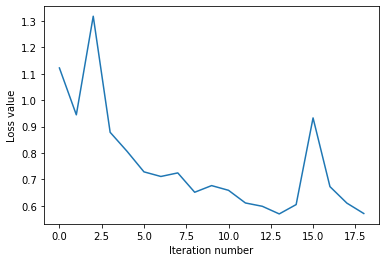

In [ ]:
# Plot loss history
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
if 'model_state_dict' in checkpoint:
  dec.load_state_dict(checkpoint['model_state_dict'])
dec.cuda()

Decoder(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Hardtanh(min_val=0, max_val=20.0, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Hardtanh(min_val=0, max_val=20.0, inplace=True)
  )
  (rnns): Sequential(
    (0): RNNWrapper(
      (rnn): GRU(2560, 105, bias=False, bidirectional=True)
    )
    (1): RNNWrapper(
      (batch_norm): OverLastDim(
        (module): BatchNorm1d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (rnn): GRU(105, 105, bias=False, bidirectional=True)
    )
    (2): RNNWrapper(
      (batch_norm): OverLastDim(
        (module): BatchNorm1d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (rnn): GRU(105, 105, bias=

Evaluation Metrics

In [ ]:
def levenshtein_distance(ref, hyp):
    """Levenshtein distance is the minimum number of single-character
    edits (substitutions, insertions or deletions) required to change 
    one word into the other.
    """
    m = len(ref)
    n = len(hyp)

    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # compute levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence at word-level.
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence at char-level.
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text at word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text at char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [ ]:
def evaluation(Y, Y_hat):
  c = 0.
  x = 0.
  y = 0.
  z = 0.
  for i, Y_hat_i in enumerate(Y_hat):
    # print('actual : ', Y[i].lower(), 'predicted : ', Y_hat_i)
    x += levenshtein_distance(Y[i].decode("utf-8"), Y_hat_i)
    y += cer(Y[i].decode("utf-8"), Y_hat_i)
    z += wer(Y[i].decode("utf-8"), Y_hat_i)
    c += 1

  return x/c, y/c, z/c

Evaluation on Validation Set

In [ ]:
with open('/content/drive/MyDrive/Fall2021-CAPSTONE/validate_list.pickle', 'rb') as f4:
  validate_list = pickle.load(f4)
print('Total validation load : ', len(validate_list))

Total validation load :  106802


In [ ]:
results_per_batch = []
load_index = 0
batch_index = 0

In [ ]:
eval_checkpoint = None
try:
  eval_checkpoint = torch.load(EVAL_CHECKPOINT, map_location=torch.device('cpu'))
except Exception as e:
  print(e)
  pass

[Errno 2] No such file or directory: '/content/drive/MyDrive/Fall2021-CAPSTONE/eval_checkpoint.pt'


In [ ]:
if eval_checkpoint is not None and bool(eval_checkpoint):
  if 'results_per_batch' in eval_checkpoint and len(eval_checkpoint['results_per_batch']) > 0:
    results_per_batch = [float(x) for x in eval_checkpoint['results_per_batch'].split(',')]

In [ ]:
print("Starting Validation Evaluation Loop...")
dec.eval()
while load_index < math.ceil(len(validate_list)/load_size):
  # create a dataset object
  dset = CustomDataset(validate_list[load_index*load_size:(load_index*load_size)+load_size])
  # wrap it around a dataloader
  data_loader = DataLoader(dset, batch_size = batch_size, num_workers = workers)

  for idx, ( X_batch, Y_batch) in enumerate(data_loader):
    if idx < batch_index:
      continue
    # forward propagation
    X_in, X_len = enc(X_batch)
    Y_pred = dec.predict(X_in.cuda())

    # evaluation
    avg_ld, avg_cer, avg_wer = evaluation(Y_batch, Y_pred)
    results_per_batch.append((avg_ld, avg_cer, avg_wer))
    batch_index += 1
  
  batch_index = 0
  load_index += 1
  print('Load', load_index)
  torch.save({
      'results_per_batch': ','.join([str(x) for x in results_per_batch])
      }, EVAL_CHECKPOINT)

Starting Validation Evaluation Loop...
Load 1
Load 2
Load 3
Load 4
Load 5
Load 6
Load 7
Load 8
Load 9
Load 10
Load 11
Load 12
Load 13
Load 14
Load 15
Load 16
Load 17
Load 18
Load 19
Load 20
Load 21
Load 22
Load 23
Load 24
Load 25
Load 26
Load 27
Load 28
Load 29
Load 30
Load 31
Load 32
Load 33
Load 34
Load 35
Load 36
Load 37
Load 38
Load 39
Load 40
Load 41
Load 42
Load 43
Load 44
Load 45
Load 46
Load 47
Load 48
Load 49
Load 50
Load 51
Load 52
Load 53
Load 54
Load 55
Load 56
Load 57
Load 58
Load 59
Load 60
Load 61
Load 62
Load 63
Load 64
Load 65
Load 66
Load 67
Load 68
Load 69
Load 70
Load 71
Load 72
Load 73
Load 74
Load 75
Load 76
Load 77
Load 78
Load 79
Load 80
Load 81
Load 82
Load 83
Load 84


In [ ]:
lds = [x[0] for x in results_per_batch]
cers = [x[1] for x in results_per_batch]
wers = [x[2] for x in results_per_batch]

In [ ]:
print('Avg. Levenshtein Distance on validation set', sum(lds)/len(lds))
print('Avg. Character Error Rate on validation set', sum(cers)/len(cers))
print('Avg. Word Error Rate on validation set', sum(wers)/len(wers))

Avg. Levenshtein Distance on validation set 12.748169562612343
Avg. Character Error Rate on validation set 0.35350644687744626
Avg. Word Error Rate on validation set 0.7240277065417712


In [ ]:
# print few results
for idx, ( X_batch, Y_batch) in enumerate(data_loader):
  if idx > 10:
    break
  # forward propagation
  X_in, X_len = enc(X_batch)
  Y_pred = dec.predict(X_in.cuda())

  for i, Y_hat_i in enumerate(Y_pred):
    print('actual : ', Y_batch[i].lower(), '\tpredicted : ', Y_hat_i)

actual :  b'because if im amazing and you asked me' 	predicted :  becausea fim an maze som andte youas
actual :  b'is the kind of game that youre' 	predicted :  is a kind of game they yoar
actual :  b'design the game such that its' 	predicted :  desine the game such that i
actual :  b'as well be honest okay' 	predicted :  is will be yu lon askame
actual :  b'miners because they do tremendous amount' 	predicted :  miners bcause a they doptrummendo someo
actual :  b'let alone take some microsecond or' 	predicted :  tat a lon thik o mike os like 
actual :  b'and try to incentivize some other part' 	predicted :  and tyc on semetifly some o o ti
actual :  b'uh whats that going to look like all' 	predicted :  to wat sac an a look like
actual :  b'but to do it its a piece of art' 	predicted :  but to doitys of piec af lon i d
actual :  b'okay what is uh whats whats the' 	predicted :  loki it what its uh whats whit 
actual :  b'yeah you know the flour everything and' 	predicted :  yeah you dot

Evaluation on test set (Note - only run once after freezing the model)

In [ ]:
with open('/content/drive/MyDrive/Fall2021-CAPSTONE/test_list.pickle', 'rb') as f5:
  test_list = pickle.load(f5)
print('Total test load : ', len(test_list))

Total test load :  106936


In [ ]:
results_per_batch = []
load_index = 0
batch_index = 0

In [ ]:
test_checkpoint = None
try:
  test_checkpoint = torch.load(TEST_CHECKPOINT, map_location=torch.device('cpu'))
except Exception as e:
  print(e)
  pass

[Errno 2] No such file or directory: '/content/drive/MyDrive/Fall2021-CAPSTONE/test_checkpoint.pt'


In [ ]:
if test_checkpoint is not None and bool(test_checkpoint):
  if 'results_per_batch' in test_checkpoint and len(test_checkpoint['results_per_batch']) > 0:
    results_per_batch = [float(x) for x in test_checkpoint['results_per_batch'].split(',')]

In [ ]:
print("Starting Test Evaluation Loop...")
dec.eval()
while load_index < math.ceil(len(test_list)/load_size):
  # create a dataset object
  dset = CustomDataset(test_list[load_index*load_size:(load_index*load_size)+load_size])
  # wrap it around a dataloader
  data_loader = DataLoader(dset, batch_size = batch_size, num_workers = workers)

  for idx, ( X_batch, Y_batch) in enumerate(data_loader):
    if idx < batch_index:
      continue
    # forward propagation
    X_in, X_len = enc(X_batch)
    Y_pred = dec.predict(X_in.cuda())

    # evaluation
    avg_ld, avg_cer, avg_wer = evaluation(Y_batch, Y_pred)
    results_per_batch.append((avg_ld, avg_cer, avg_wer))
    batch_index += 1
  
  batch_index = 0
  load_index += 1
  print('Load', load_index)
  torch.save({
      'results_per_batch': ','.join([str(x) for x in results_per_batch])
      }, TEST_CHECKPOINT)

Starting Test Evaluation Loop...
Load 1
Load 2
Load 3
Load 4
Load 5
Load 6
Load 7
Load 8
Load 9
Load 10
Load 11
Load 12
Load 13
Load 14
Load 15
Load 16
Load 17
Load 18
Load 19
Load 20
Load 21
Load 22
Load 23
Load 24
Load 25
Load 26
Load 27
Load 28
Load 29
Load 30
Load 31
Load 32
Load 33
Load 34
Load 35
Load 36
Load 37
Load 38
Load 39
Load 40
Load 41
Load 42
Load 43
Load 44
Load 45
Load 46
Load 47
Load 48
Load 49
Load 50
Load 51
Load 52
Load 53
Load 54
Load 55
Load 56
Load 57
Load 58
Load 59
Load 60
Load 61
Load 62
Load 63
Load 64
Load 65
Load 66
Load 67
Load 68
Load 69
Load 70
Load 71
Load 72
Load 73
Load 74
Load 75
Load 76
Load 77
Load 78
Load 79
Load 80
Load 81
Load 82
Load 83
Load 84


In [ ]:
lds = [x[0] for x in results_per_batch]
cers = [x[1] for x in results_per_batch]
wers = [x[2] for x in results_per_batch]

In [ ]:
print('Avg. Levenshtein Distance on test set', sum(lds)/len(lds))
print('Avg. Character Error Rate on test set', sum(cers)/len(cers))
print('Avg. Word Error Rate on test set', sum(wers)/len(wers))

Avg. Levenshtein Distance on test set 12.745196417884927
Avg. Character Error Rate on test set 0.35310290516075804
Avg. Word Error Rate on test set 0.72458834360025


In [ ]:
# print few results
for idx, ( X_batch, Y_batch) in enumerate(data_loader):
  if idx > 10:
    break
  # forward propagation
  X_in, X_len = enc(X_batch)
  Y_pred = dec.predict(X_in.cuda())

  for i, Y_hat_i in enumerate(Y_pred):
    print('actual : ', Y_batch[i].lower(), '\tpredicted : ', Y_hat_i)

actual :  b'something uh nuclear war and all the' 	predicted :  somforng un you clere warn nex al
actual :  b'easy reconstruct the glass hard' 	predicted :  esegostect lat iges act
actual :  b'function which you have a recipe that is' 	predicted :  funktio beci ob ira ressit be thet t
actual :  b'that we think of the most powerful gods' 	predicted :  thatt we fhinko they last poerf gol
actual :  b'the gods of love and death and when you' 	predicted :  the goids  l lov len that a when
actual :  b'erase one another you create something' 	predicted :  ar has whone o haver yo caet something
actual :  b'you know that you have been paid' 	predicted :   you an al that tie youl ben pad
actual :  b'so for reason in pseudorandom number' 	predicted :  sofoisand in so or kone to nom
actual :  b'morphs in cells in digital signature' 	predicted :  amots insevin teg got asii
actual :  b'the easy and the hard and in my opinion' 	predicted :  thesim the hird and mhin mit be te
actual :  b'lets uh lets 